# ***IMPORTS***

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# ***MOUNT DRIVE***

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***PATHS (EDIT)***

In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/Project work/Dataset/Epic and CSCR hospital Dataset_clean/Train"
TEST_DIR  = "/content/drive/MyDrive/Project work/Dataset/Epic and CSCR hospital Dataset_clean/Test"

MODEL_PATH = "/content/drive/MyDrive/Project work/models/tumor_mobilenet_v3.keras"


In [ ]:
os.path.exists(TRAIN_DIR)
os.path.exists(TEST_DIR)

True

# ***CONFIG***

In [ ]:
IMG_SIZE = 384
BATCH_SIZE = 16
SEED = 42

WARMUP_EPOCHS = 3
HEAD_EPOCHS   = 5
FT1_EPOCHS    = 6
FT2_EPOCHS    = 4

TARGET_ACC = 0.90

AUTOTUNE = tf.data.AUTOTUNE
GRAPHS = []

# ***LOAD DATA***

In [ ]:
train_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_raw = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_raw.class_names
NUM_CLASSES = len(class_names)

print("Classes:", class_names)


Found 9650 files belonging to 4 classes.
Using 7720 files for training.
Found 9650 files belonging to 4 classes.
Using 1930 files for validation.
Found 2180 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# ***AUGMENTATION***

In [ ]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.15)
])


def train_preprocess(x, y):
    x = augment(x, training=True)
    x = preprocess_input(x)
    return x, y


def val_preprocess(x, y):
    x = preprocess_input(x)
    return x, y


train_ds = train_raw.map(train_preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = val_raw.map(val_preprocess, num_parallel_calls=AUTOTUNE)
test_ds  = test_raw.map(val_preprocess, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# ***CLASS WEIGHTS***

In [ ]:
labels = []

for _, y in train_raw:
    labels.extend(np.argmax(y.numpy(), axis=1))

labels = np.array(labels)

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(weights))

print("Class weights:", class_weights)

Class weights: {0: np.float64(0.8004977187888843), 1: np.float64(1.107921928817451), 2: np.float64(1.238767650834403), 3: np.float64(0.9606769537083126)}


# ***CALLBACKS***

In [ ]:
callbacks = [

    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        monitor="val_loss",
        save_best_only=True
    ),

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=2,
        factor=0.3,
        min_lr=1e-6
    )
]


# ***BUILD MODEL***

In [ ]:
# NOTE:
# TensorFlow does NOT yet officially expose MobileNetV4.
# MobileNetV3Large is currently the closest stable replacement.

base_model = MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False


inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))

x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(256, activation="swish")(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(
    NUM_CLASSES,
    activation="softmax"
)(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 12, 12, 960)    │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 960)            │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,247,236 (12.39 MB)

 Trainable params: 248,964 (972.52 KB)

 Non-trainable params: 2,998,272 (11.44 MB)

# ***LOSS & METRICS***

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

metrics = [
    "accuracy",
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

# ***WARMUP***

In [ ]:

print("Warmup...")

model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-3),
    loss=loss_fn,
    metrics=metrics
)

hist_warmup = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=WARMUP_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

model.load_weights("best_model.h5")
GRAPHS.append(hist_warmup)

Warmup...
Epoch 1/3
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7568 - loss: 0.9066 - precision: 0.7938 - recall: 0.7187

483/483 ━━━━━━━━━━━━━━━━━━━━ 138s 232ms/step - accuracy: 0.7569 - loss: 0.9064 - precision: 0.7939 - recall: 0.7188 - val_accuracy: 0.8953 - val_loss: 0.6074 - val_precision: 0.9188 - val_recall: 0.8622 - learning_rate: 0.0010
Epoch 2/3
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8844 - loss: 0.6167 - precision: 0.9084 - recall: 0.8461

483/483 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.8844 - loss: 0.6166 - precision: 0.9085 - recall: 0.8461 - val_accuracy: 0.9326 - val_loss: 0.5197 - val_precision: 0.9579 - val_recall: 0.9078 - learning_rate: 0.0010
Epoch 3/3
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9206 - loss: 0.5508 - precision: 0.9443 - recall: 0.8852

483/483 ━━━━━━━━━━━━━━━━━━━━ 43s 86ms/step - accuracy: 0.9206 - loss: 0.5508 - precision: 0.9443 - recall: 0.8852 - val_accuracy: 0.9477 - val_loss: 0.4926 - val_precision: 0.9692 - val_recall: 0.9306 - learning_rate: 0.0010


# ***HEAD TRAINING***

In [ ]:

print("Head Training...")

hist_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=HEAD_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

model.load_weights("best_model.h5")
GRAPHS.append(hist_head)

Head Training...
Epoch 1/5
483/483 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.9293 - loss: 0.5286 - precision: 0.9486 - recall: 0.8959 - val_accuracy: 0.9440 - val_loss: 0.4967 - val_precision: 0.9567 - val_recall: 0.9269 - learning_rate: 0.0010
Epoch 2/5
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9419 - loss: 0.5139 - precision: 0.9603 - recall: 0.9129

483/483 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.9419 - loss: 0.5139 - precision: 0.9603 - recall: 0.9129 - val_accuracy: 0.9528 - val_loss: 0.4845 - val_precision: 0.9655 - val_recall: 0.9415 - learning_rate: 0.0010
Epoch 3/5
483/483 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.9410 - loss: 0.5080 - precision: 0.9590 - recall: 0.9114 - val_accuracy: 0.9503 - val_loss: 0.4890 - val_precision: 0.9622 - val_recall: 0.9358 - learning_rate: 0.0010
Epoch 4/5
481/483 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9443 - loss: 0.4981 - precision: 0.9610 - recall: 0.9237

483/483 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.9443 - loss: 0.4981 - precision: 0.9611 - recall: 0.9237 - val_accuracy: 0.9539 - val_loss: 0.4731 - val_precision: 0.9679 - val_recall: 0.9383 - learning_rate: 0.0010
Epoch 5/5
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9455 - loss: 0.4977 - precision: 0.9627 - recall: 0.9224

483/483 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.9455 - loss: 0.4977 - precision: 0.9627 - recall: 0.9224 - val_accuracy: 0.9570 - val_loss: 0.4698 - val_precision: 0.9696 - val_recall: 0.9404 - learning_rate: 0.0010


# ***FINE-TUNE 50%***

In [ ]:

print("Fine-tune 50%...")

n = len(base_model.layers)
unfreeze = int(0.5 * n)

for layer in base_model.layers[unfreeze:]:
    layer.trainable = True


model.compile(
    optimizer=tf.keras.optimizers.AdamW(5e-5),
    loss=loss_fn,
    metrics=metrics
)

hist_ft1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT1_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

model.load_weights("best_model.h5")
GRAPHS.append(hist_ft1)

Fine-tune 50%...
Epoch 1/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 112s 154ms/step - accuracy: 0.8828 - loss: 0.6219 - precision: 0.9455 - recall: 0.8788 - val_accuracy: 0.8917 - val_loss: 0.8002 - val_precision: 0.9063 - val_recall: 0.8824 - learning_rate: 5.0000e-05
Epoch 2/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.9594 - loss: 0.4821 - precision: 0.9741 - recall: 0.9350 - val_accuracy: 0.9290 - val_loss: 0.6174 - val_precision: 0.9434 - val_recall: 0.9155 - learning_rate: 5.0000e-05
Epoch 3/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 43s 86ms/step - accuracy: 0.9757 - loss: 0.4509 - precision: 0.9848 - recall: 0.9617 - val_accuracy: 0.9617 - val_loss: 0.4945 - val_precision: 0.9710 - val_recall: 0.9539 - learning_rate: 5.0000e-05
Epoch 4/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9814 - loss: 0.4368 - precision: 0.9895 - recall: 0.9675

483/483 ━━━━━━━━━━━━━━━━━━━━ 43s 88ms/step - accuracy: 0.9813 - loss: 0.4368 - precision: 0.9895 - recall: 0.9675 - val_accuracy: 0.9829 - val_loss: 0.4437 - val_precision: 0.9884 - val_recall: 0.9725 - learning_rate: 5.0000e-05
Epoch 5/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9856 - loss: 0.4267 - precision: 0.9920 - recall: 0.9752

483/483 ━━━━━━━━━━━━━━━━━━━━ 43s 88ms/step - accuracy: 0.9856 - loss: 0.4267 - precision: 0.9920 - recall: 0.9752 - val_accuracy: 0.9824 - val_loss: 0.4268 - val_precision: 0.9890 - val_recall: 0.9777 - learning_rate: 5.0000e-05
Epoch 6/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9904 - loss: 0.4164 - precision: 0.9937 - recall: 0.9798

483/483 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.9904 - loss: 0.4164 - precision: 0.9937 - recall: 0.9798 - val_accuracy: 0.9829 - val_loss: 0.4175 - val_precision: 0.9905 - val_recall: 0.9772 - learning_rate: 5.0000e-05


# ***FULL FINE-TUNE***

In [ ]:

best_val = max(hist_ft1.history["val_accuracy"])

print("Best Val Acc:", best_val)

if best_val < TARGET_ACC:

    print("Full Fine-Tuning...")

    base_model.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(2e-5),
        loss=loss_fn,
        metrics=metrics
    )

    hist_ft2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FT2_EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights
    )

    model.load_weights("best_model.h5")
    GRAPHS.append(hist_ft2)

Best Val Acc: 0.9829015731811523


# ***PLOT TRAINING***

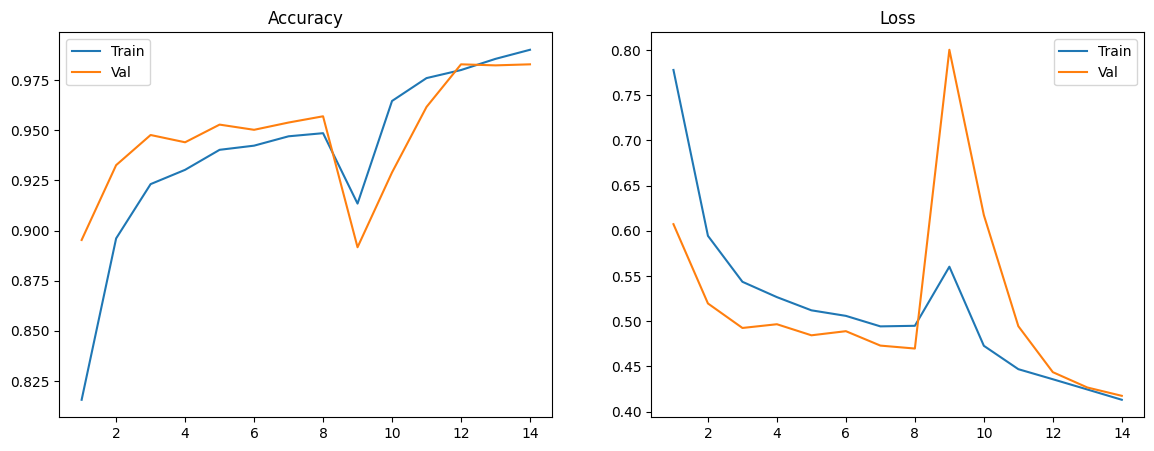

In [ ]:
def plot_history(histories):

    acc, val_acc, loss, val_loss = [], [], [], []

    for h in histories:
        acc += h.history["accuracy"]
        val_acc += h.history["val_accuracy"]
        loss += h.history["loss"]
        val_loss += h.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="Train")
    plt.plot(epochs, val_acc, label="Val")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="Train")
    plt.plot(epochs, val_loss, label="Val")
    plt.legend()
    plt.title("Loss")

    plt.show()


plot_history(GRAPHS)

# ***TEST ***

In [ ]:
print("Evaluating Test Set...")

model.evaluate(test_ds)

Evaluating Test Set...
137/137 ━━━━━━━━━━━━━━━━━━━━ 102s 746ms/step - accuracy: 0.9657 - loss: 0.4659 - precision: 0.9721 - recall: 0.9467


[0.4734596610069275,
 0.9591743350028992,
 0.9702690243721008,
 0.9431192874908447]

# ***CONFUSION MATRIX***

In [ ]:
y_true = []
y_pred = []

for x, y in test_ds:

    preds = model.predict(x, verbose=0)

    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))


cm = confusion_matrix(y_true, y_pred)

print("Classification Report:\n")

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


Classification Report:

              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       750
  meningioma       0.94      0.93      0.94       518
     notumor       0.97      1.00      0.98       455
   pituitary       0.95      1.00      0.97       457

    accuracy                           0.96      2180
   macro avg       0.96      0.96      0.96      2180
weighted avg       0.96      0.96      0.96      2180



# ***SAVE***

In [ ]:


model.save(MODEL_PATH)
model.save(MODEL_PATH.replace(".keras", ".h5"))

print("Saved:", MODEL_PATH)


Saved: /content/drive/MyDrive/Project work/models/tumor_mobilenet_v3.keras
